In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e4/sample_submission.csv
/kaggle/input/playground-series-s5e4/train.csv
/kaggle/input/playground-series-s5e4/test.csv


In [34]:
import pandas as pd
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

import sklearn.preprocessing as pp
import category_encoders as ce
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import cross_val_score

In [37]:
train_data = pd.read_csv('/kaggle/input/playground-series-s5e4/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s5e4/test.csv')
train_data.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


<Axes: >

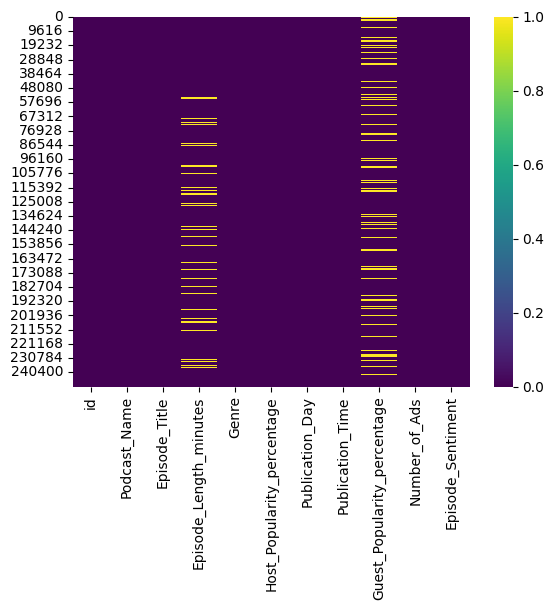

In [8]:
sns.heatmap(test_data.isna(), cmap='viridis')

In [9]:
train_data.shape

(750000, 12)

sns.set_theme()

melted = train_data.melt()

g = sns.FacetGrid(melted,
                  col='variable',
                  col_wrap=3,
                  sharex=False,
                  sharey=False)

g.map(sns.histplot, 'value')

g.set_titles(col_template='{col_name}')

g.tight_layout()

In [51]:
target_variable = 'Listening_Time_minutes'
X_train = train_data.sample(5000, random_state=42)
y_train = X_train.pop(target_variable)

In [52]:
train_data.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.000000,662907.000000,750000.000000,603970.000000,749999.000000,750000.000000
mean,374999.500000,64.504738,59.859901,52.236449,1.348855,45.437406
std,216506.495284,32.969603,22.873098,28.451241,1.151130,27.138306
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,35.730000,39.410000,28.380000,0.000000,23.178350
50%,374999.500000,63.840000,60.050000,53.580000,1.000000,43.379460
75%,562499.250000,94.070000,79.530000,76.600000,2.000000,64.811580
max,749999.000000,325.240000,119.460000,119.910000,103.910000,119.970000


In [53]:
X_train.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads
count,5000.00000,4400.000000,5000.00000,3997.000000,5000.000000
mean,376341.41540,63.808864,60.29417,51.777045,1.356800
std,214059.50961,33.207741,23.10366,28.657543,1.129313
min,158.00000,5.010000,20.08000,0.040000,0.000000
25%,193334.75000,34.862500,39.44000,27.780000,0.000000
50%,373910.50000,62.505000,60.31000,53.290000,1.000000
75%,563317.25000,93.500000,80.21000,76.320000,2.000000
max,749975.00000,119.980000,99.99000,99.910000,3.000000


In [16]:
train_data.select_dtypes(include='object').nunique()

Podcast_Name          48
Episode_Title        100
Genre                 10
Publication_Day        7
Publication_Time       4
Episode_Sentiment      3
dtype: int64

In [18]:
delete_features = ['id', 'Podcast_Name', 'Episode_Title']
missing_data_festures = list(train_data.columns[train_data.isna().sum().ge(1)])
missing_data_festures

Index(['Episode_Length_minutes', 'Guest_Popularity_percentage',
       'Number_of_Ads'],
      dtype='object')

In [19]:
train_data.isna().sum()

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
dtype: int64

In [24]:
train_data.groupby(['Genre'])[missing_data_festures].mean()

,Episode_Length_minutes,Guest_Popularity_percentage,Number_of_Ads
Genre,,,
Business,64.537846,51.221996,1.373505
Comedy,63.300076,53.361264,1.306096
Education,64.979055,52.315205,1.398982
Health,65.294750,51.441920,1.382313
Lifestyle,64.837087,51.757045,1.311408
Music,65.991298,52.052459,1.318956
News,63.720797,52.436838,1.384539
Sports,64.290514,53.076768,1.363290
Technology,64.034032,51.836737,1.350329


In [40]:
class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self, groupby='Podcast_Name'):
        self.missing_columns = []
        self.averages = None
        self.groupby = groupby

    def fit(self, X, y=None):
        self.missing_columns = list(train_data.columns[train_data.isna().sum().ge(1)])
        self.averages = X.groupby(self.groupby)[self.missing_columns].mean()
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.missing_columns:
            X[col] = X.apply(lambda x: x[col] if not np.isnan(x[col]) \
                             else self.averages.loc[x[self.groupby], col], axis=1)
        return X

In [41]:
numeric_transformer = Pipeline(steps=[
    ('scaling', pp.StandardScaler())
])

onehot_transformer = Pipeline(steps=[
    ('onehot_encoging', pp.OneHotEncoder())
])

target_transformer = Pipeline(steps=[
    ('target_encoging', ce.TargetEncoder()),
    ('scaling', pp.StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('numerical', numeric_transformer, make_column_selector(dtype_include=np.number)),
    ('categorical', onehot_transformer, make_column_selector(dtype_include='object')),
])

model = Pipeline(steps=[
    ('imputer', CustomImputer('Podcast_Name')),
    ('delete columns', FunctionTransformer(lambda x: x.drop(
        columns=['id', 'Podcast_Name', 'Episode_Title']))),
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
model

Pipeline(steps=[('imputer', CustomImputer()),
                ('delete columns',
                 FunctionTransformer(func=<function <lambda> at 0x7bc669186c00>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7bc6704adb50>),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot_encoging',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7bc669827090>)])),
                ('model', LinearRegression())])

In [42]:
validation = cross_val_score(
    estimator = model,
    X = X_train,
    y = y_train,
    cv = 5,
    n_jobs = -1,
    scoring = 'neg_root_mean_squared_error',
    verbose = 5
)
validation.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


array([-13.25425591, -13.48571474, -12.6777557 , -13.70932338,
       -12.53034302])

In [44]:
model.fit(X_train, y_train)
prediction = model.predict(test_data)

In [46]:
submission = pd.read_csv('/kaggle/input/playground-series-s5e4/sample_submission.csv')
submission.head()

,id,Listening_Time_minutes
0,750000,45.437
1,750001,45.437
2,750002,45.437
3,750003,45.437
4,750004,45.437


In [47]:
submission[target_variable] = prediction
submission.to_csv('submission.csv', index=False)